#### **1. Introduction to Transformers**

Since Google introduced the Transformer architecture in 2017, it has rapidly become a fundamental component in the advancement of deep learning technologies. Its significance lies in its innovative approach to processing sequential data, which makes it critical for various state-of-the-art applications like [Vision Transformers](https://arxiv.org/abs/2010.11929) (ViT), [Contrastive Language-Image Pre-training](https://arxiv.org/abs/2103.00020v1)(CLIP), and [Alphafold](https://www.nature.com/articles/s41586-021-03819-2). The architecture's unique features address key challenges in deep learning, such as efficient data processing and the ability to capture complex relationships within the data.

The Transformer comprises two main parts: the encoder and the decoder. This discussion first focuses on the encoder, introducing the basic principles of the Transformer architecture that have become popular in many deep learning models. 

**Figure 1** provides a schematic of the Transformer encoder,  structured as a stack of $N$ identical layers. Each layer consists of a *multi-head attention layer* (**Figure 1a**) and a *fully-connected dense neural network* (FCNN, **Figure 1b**). The multi-head attention layer is particularly important as it enables the neural network to leverage intrinsic relationships between the input data's features. Moreover, it provides Transformers with a key computational advantage: parallelization.  The fully-connected dense neural network, in turn, is used to integrate and refine data processed by the multi-head attention layer, enhancing the understanding and representation of the input data.


<p align="center">
  <img src="images/transformer_fig_1.png" width=200 height=auto>
  <br>
  <b>Figure 1. Transformer encoder.</b>
</p>

#### **2. Understanding Multi-Head Attention**

The Transformer"s encoder has a Multi-Head Attention layer at its core. This layer is crucial for the model to understand sequential data"s intricacies. It has multiple attention "*heads*", each of which works independently to analyze various aspects of the input data's relationships (**Figure 2**).

<p align="center">
  <img src="images/transformer_fig_2.png" width=400 height=auto>
  <br>
  <b>Figure 2. A multi-head attention layer operates as a set of parallel self-attention heads.</b>
</p>

A sentence is a natural way of representing a sequence. Words are arranged logically to convey meaning. For instance, consider the sentence in Figure 3a: "*The man fell from the chair because it was flimsy*." For humans, deriving semantic information from this sentence is straightforward. We can answer questions like "Does *flimsy* refer to the man or the *chair*?" without much effort. However, for an algorithm, this task is more challenging.

Attention heads use *self-attention* to comprehend the underlying relational structure of an input sequence.  In our example, this mechanism allows the model to evaluate the importance of each word in the sentence in relation to the others. Put simply, the model acquires the ability to identify the connections between words in the sentence. As the self-attention mechanism processes each word, it can recognize the correlation between the words 'flimsy' and 'chair', enabling each word to "attend" to other positions in the input sequence for hints that could assist in encoding its representation better.


<p align="center">
  <img src="images/transformer_fig_3.png" width=500 height=auto>
  <br>
  <b>Figure 3. Input sequence representation.</b>
</p>

The input sequence is represented by a matrix, denoted by $X \in \mathbb{R}^{n \times d}$. Here, $n$ is the sequence length, and $d$ is the number of features that represent each element, as shown in **Figure 3b**. Words, for example, cannot be fed directly into the model. Instead, they are first transformed into a vector representation (how this is done will be discussed later). The input sequence is then transformed into three matrices: the query matrix $Q \in \mathbb{R}^{n \times d_m}$, the key matrix $K \in \mathbb{R}^{n \times d_m}$, and the value matrix $V \in \mathbb{R}^{n \times d_m}$, where $d_m$ is the latent dimensionality of the self-attention module. These matrices are calculated by multiplying the input sequence by three different weight matrices, $W^Q$, $W^K$, and $W^V$, respectively (**Figure 4**). These weight matrices are initialized randomly and are learned during the training process.

<p align="center">
  <img src="images/transformer_fig_4.png" width=600 height=auto>
  <br>
  <b>Figure 4. The input sequence is transformed into query, key, and value matrices.</b>
</p>

The concept of self-attention is based on the idea that every element in a sequence can be represented as a linear combination of the other elements in the sequence. To achieve this, we calculate the dot product of the query and key vectors for each element, resulting in an $n × n$ matrix where each element $(i, j)$ is the dot product between the query vector of the $i$-th element and the key vector of the $j$-th element. This matrix is then normalized by dividing each element by the square root of the latent dimensionality of the self-attention module (i.e., $d_m$), and applying the softmax function (as shown in **Figure 5a**). The normalized matrix is called the attention matrix, $A$ (**Figure 5b**), in which each element $(i, j)$ represents the importance of the $j$-th element in the representation of the $i$-th element.

For clarity, consider the example shown in **Figure 5b**, where the importance of each element is color-coded in a heat map format. A properly trained self-attention module should assign high values to semantically similar elements in the same row. For instance, the importance of the word "flimsy" in the representation of "chair" should be high because they're mutually descriptive words. 

To calculate the output of the self-attention module, we multiply the attention matrix $A$ by the value matrix $V$ (as shown in **Figure 5c**). The resulting matrix has a shape of $(n, d_m)$, where the representation of each element is a linear combination of the representations of all other elements in the sequence. This is why this module is called self-attention because it allows each element to interact with the others and learn which representations it should pay attention to.

<p align="center">
  <img src="images/transformer_fig_5.png" width=700 height=auto>
  <br>
  <b>Figure 5. Self-attention mechanism.</b>
</p>

Finally, the output of each attention head is concatenated and combined with a linear transformation to produce the final output of the multi-head attention layer.

#### **3. Implementing a Transformer Encoder for sentiment analysis**

Now, we will implement a Transformer encoder to perform sentiment analysis, a well-known task in Natural Language Processing (NLP) that involves categorizing text.


#### **3.1 The IMDB dataset**

Let us start by downloading the [Large Movie Review Dataset](https://huggingface.co/datasets/imdb) (often referred to as the IMDB dataset). It contains 50,000 movie reviews, labeled as positive or negative. The dataset is divided into 25,000 reviews for training and 25,000 reviews for testing. 

Use the following code snippet to download and prepare the data:

In [24]:
from datasets import load_dataset

dataset = load_dataset("imdb")

`dataset` is dictionary that contains the training and testing sets. Each set is also a dictionary with two keys: `"text"` and `"label"`. The `"text"` key contains movie reviews, while the `"label"` key contains the sentiment of the review, where 0 denotes a negative sentiment and 1 denotes a positive sentiment.

Before moving forward, it's important to split the training set into two parts: training and validation. We will use 20% of the training set as a validation set during the training process.

In [25]:
split = dataset["train"].train_test_split(
    test_size=0.2, # (1)
    stratify_by_column="label", # (2)
    seed=42,  # (3)
)
train_dataset, val_dataset = split["train"], split["test"]

The code above **(1)** splits the train portion of the dataset into two subsets: a training dataset and a validation dataset. The split is determined by the `test_size` parameter, which specifies that 20% of the data should be allocated for validation.

**(2)** The `stratify_by_column="label"` argument ensures that the split retains the same distribution of labels in both the training and validation datasets as in the original dataset, which is beneficial for maintaining a balanced representation of classes. 
 
**(3)** The `seed=42` argument sets a seed for the random number generator to ensure reproducibility of the split.

Visualize three example reviews from the training set:

In [33]:
import numpy as np
import pandas as pd

examples = train_dataset.select(np.random.randint(0, len(train_dataset), 3))    # Selecting 3 examples from the training dataset
df = pd.DataFrame({"Text": examples["text"], "Label": examples["label"]})       # Creating a DataFrame
styled_df = df.style.set_properties(**{"text-align": "left"}).set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)
with pd.option_context("display.max_colwidth", None):
    display(styled_df)

,Text,Label
0,"Peter O'Toole is a treat to watch in roles where the lines he speaks are good and offer a chance for him to swagger in drunken stupor. The lovely Susannah York provides a good foil for O'Toole's dramatic presence.The film alludes to incest--without a single explicit scene--but it is able to entertain the viewer in its raucous social commentary. Though this is not major film by any reckoning, it will be remembered for its entertaining performances. Even York, signing the papers at the end, is a treat to watch, exuding tragedy silently. The possible weakness here is Thompson's laid-back direction. But the film floats because of the actors and the script.I saw the film twice over a period of 20 years--on both occasions with the name ""Brotherly love"". ""Country dance"" is a rather farcical and inappropriate title for this movie, wherever it was released as such.",1
1,"Made by french brothers Jules and Giddeon Naudet, and narrated by Robert De Niro and Firefighter James Hanlon this is a compelling and heartbreaking tale of how New York's finest shone on it's darkest day. I first saw this when I was a young naive 12 year old, and at that age it still touched me. Knowing how serious 9/11 really was seeing this expanded the whole effect of 9/11. We were finding out who the heroes were, how there everyday lives were composed, and how they put their lives on the line in a situation where most people would just run and save their selves. These brave men put their lives on the line and watching this just increases my admiration for them. Watch if you can,this is the best documentary I have personally ever seen.",1
2,"I saw the movie late one night on cable and could not believe how bad it was. I usually enjoy bad movies, but this one was so revolting that it wasn't even entertaining. Some of the highlights of this film include the absurd music which is constantly playing throughout the movie, the hideous special effects (when someone is shot with a laser gun they turn neon green and promptly disintegrate), and the disgusting acting. The acting, in fact, is what I feel steals the show. I didn't recognize any of the actors in the movie, and I hope that I never have to see any of them again. Overall, I recommend renting this movie (if you can find it; I can't imagine a video store carrying this garbage) just so that you can learn to appreciate quality films after seeing this trash.",0


#### **3.2 Data Preprocessing**

The first step in processing the data is *tokenization*. It involves breaking down a sentence into individual words or subwords. This process is extremely important in Natural Language Processing, as it helps the model to comprehend the structure of the input data.

There are a [variety of tokenization methods](https://huggingface.co/learn/nlp-course/chapter2/4) available, each with its own set of advantages and drawbacks. The following code snippet creates a `tokenizer` object that splits the input text into tokens by using punctuation and white spaces.

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [34]:
def tokenize(text):
    """Tokenize text."""
    return tokenizer(text)

Consider the sentence:

It is tokenized into the following list of tokens:

In [35]:
print(tokenize("This is a simple example!"))

['this', 'is', 'a', 'simple', 'example', '!']

#### **3.2.1 Handling contractions**

However, the training data is more complicated than the example given above. It contains various types of words, punctuations, contractions, and other linguistic elements that require proper handling. Contractions, in particular, can pose a challenge to model training.

Contractions are linguistic shortcuts that combine two words into one, often to mimic the spoken language and make writing more fluid. Some common examples include “*don't*” (for “*do not*”), “*I'm*” (for “*I am*”), and “*I've*” (for “*I have*”).

Contractions are commonly used in spoken and written English, yet they can create difficulties for language models as they introduce variability. This is because contractions can represent the same idea in multiple forms. For example, “*it is*”, “*it's*”, and sometimes even “*tis*” can all convey the same meaning but are expressed differently.

Depending on the task, an NLP model may struggle to recognize that these different forms have the same underlying meaning, leading to errors in understanding and processing text.

The following code snippet standardizes the text by converting contractions into their expanded forms:

In [ ]:
import contractions

def tokenize(text):
    """Tokenize text."""
    standardized_text = contractions.fix(text)
    return tokenizer(standardized_text)

Consider the sentence:

In [38]:
print(tokenize("I can't believe that it's attention all you'll ever need!"))

['i',
 'can',
 "'",
 't',
 'believe',
 'that',
 'it',
 "'",
 's',
 'attention',
 'all',
 'you',
 "'",
 'll',
 'ever',
 'need',
 '!']

Note that cases such as “*can´t*”, “*we´re*”, “*gonna*”, and “*it´s*” are handled correctly.

This standardization is important since it guarantees semantic consistency and robustness for various writing styles.

#### **3.2.2 Removing noise**

Text, like any other data, contains noise. In the context of NLP, noise is everything that is not semantically relevant to the task at hand. Punctuation, question/exclamation marks, quotes, and non-alphabetic characters are often considered noise.

The following code snippet performs additional processing on the text by removing any unnecessary noise or unwanted elements:

In [48]:
import re

def tokenize(text):
    """Tokenize text."""
    text = contractions.fix(text)                                               # Expand contractions in the text

    replacements = {"’": "'", "‘": "'", "“": '"', "”": '"', "´": "'", "´´": '"'}# Standardize different types of quotes and apostrophes
    for old, new in replacements.items():
        text = text.replace(old, new)
    
    tokens = tokenizer(text)                                                    # Tokenize the standardized text
    
    filtered_tokens = [
        token for token in tokens
        if re.match(r"^[a-zA-Z0-9]+(-[a-zA-Z0-9]+)*(_[a-zA-Z0-9]+)*$", token)   # Filter tokens using regex to include only alphanumeric characters, hyphens, and underscores
    ]
    
    return filtered_tokens

After standardizing contractions, **(1)** the text undergoes a second standardization process where different types of quotation marks and apostrophes (’, ‘, “, ”, ´, and ´´) are replaced with their ASCII equivalents (' for apostrophes and " for quotation marks). This standardization makes the text easier to process by ensuring consistency in punctuation marks, which is especially important for tokenization and further text analysis tasks.

**(2)** The code filters the tokens based on a regular expression pattern. The pattern `r"^[a-zA-Z0-9]+(-[a-zA-Z0-9]+)*(_[a-zA-Z0-9]+)*$"` is designed to match tokens that consist of alphanumeric characters (a-zA-Z0-9), and these characters can be optionally connected by hyphens (-) or underscores (_), in the case of compound words or phrases.


For example:

In [49]:
print(tokenize("It isn't just useful, but crucial, to double-check your code!"))

['it', 'is', 'not', 'just', 'useful', 'but', 'crucial', 'to', 'double-check', 'your', 'code']


#### **3.2.3 Creating a vocabulary**

Up until now, we have a function that performs standardization, cleaning, and tokenization of the text. 

The following step is to transform the tokens into numerical representations. In order to do this, we need to create a vocabulary which maps each token to a unique integer. A vocabulary is a set of distinct words in a dataset, and it is formed by iterating through the tokens and adding them to the set.

The following code snippet creates a vocabulary from the training dataset:

In [50]:
from torchtext.vocab import build_vocab_from_iterator

def iterator(dataset):
    """Iterate over the IMBD dataset."""
    for data in dataset:
        yield tokenize(data["text"])

vocab = build_vocab_from_iterator(iterator(train_dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

**(1)** `imdb_iterator` is defined to iterate over the dataset. For each item in the dataset, it yields the tokenized version of the text data. 

**(2)** `build_vocab_from_iterator` is used to build the vocabulary. It takes an iterator as its first argument, which, in this case, is provided by calling the `imdb_iterator` function on the training dataset.

**(3)** The specials argument is used to define special tokens that should be included in the vocabulary. In this case, `["<unk>"]` is passed, which means a special token `<unk>` (usually representing "unknown" tokens that are not found in the vocabulary) is added to the vocabulary. 

**(4)** `vocab.set_default_index(vocab["<unk>"])` sets the default index that will be returned by the vocabulary when a token is not found. This is crucial for handling out-of-vocabulary words during the processing of text, ensuring that the model can handle words it hasn't seen before in a standardized way.


`vocab` works as a lookup table that assigns a unique integer to each token in the dataset. 

For example:

In [55]:
for token in ["the", "movie", "was", "amazing", "and", "i", "loved", "it"]:
    print(f"{token}: {vocab[token]}")

the: 1
movie: 17
was: 13
amazing: 462
and: 2
i: 9
loved: 426
it: 7


We can now apply the standardization, cleaning, tokenization, and numerical representation to the training dataset:

In [56]:
def preprocessing(sample):
    """Preprocess the input data."""
    tokens = tokenize(sample["text"])
    sample.update({"x": vocab(tokens)}) 
    return sample

train_dataset = train_dataset.map(preprocessing)

Map: 100%|██████████| 20000/20000 [00:15<00:00, 1261.12 examples/s]


**(1)** defines the `preprocess` function. This function has two main steps. **(2)** First, it performs tokenization and data cleaning on the input data. **(3)** Second, it maps the tokens to their corresponding numerical indices using the `vocab` object. These indices are then added to the original sample dictionary under the key `"x"`.

Finally, **(4)** applies the preprocessing function to every element in `train_dataset`.

We will also apply the same preprocessing to the validation

In [57]:
val_dataset = val_dataset.map(preprocessing)

Map: 100%|██████████| 5000/5000 [00:04<00:00, 1184.59 examples/s]


and test datasets

In [58]:
test_dataset = dataset["test"].map(preprocessing)

Map: 100%|██████████| 25000/25000 [00:17<00:00, 1434.91 examples/s]


#### **3.3 Building a Transformer Encoder Layer**

We will now explore how to implement a Transformer encoder layer. As discussed earlier, this layer consists of two essential components: a multi-head attention layer and a fully-connected feedforward neural network.

The workflow within a Transformer encoder layer starts with the input of a sequence of tokens. These tokens first encounter the multi-head attention layer, which processes them to produce an intermediate output (**Figure 6a**). This output is then merged back with the original input through a residual connection, and the combined result undergoes layer normalization to maintain stability in the network's learning process (**Figure 6b**).

Following this, the process mirrors itself with the fully connected feedforward neural network. This network takes the normalized output from the multi-head layer and subjects it to a sequence of linear transformations and activation functions (**Figure 6c**). The resultant output is again combined with its input (the normalized output from the multi-head attention stage) through another residual connection. Finally, layer normalization is applied to this combined output (**Figure 6d**).

<p align="center">
  <img src="images/transformer_fig_6.png" width=200 height=auto>
  <br>
  <b>Figure 6. Transformer encoder layer.</b>
</p>


Let's start by implementing the multi-head attention layer.

In [59]:
import torch
import torch.nn as nn
import deeplay as dl

class MultiHeadAttentionLayer(dl.DeeplayModule):
    """"Multi-head attention layer."""
    
    def __init__(self, features, num_heads):
        """Initialize multi-head attention layer."""
        super().__init__()
        self.features, self.num_heads = features, num_heads
        self.layer = dl.Layer(nn.MultiheadAttention, features, num_heads)

    def forward(self, x, batch_indices):
        """Calculate forward pass."""
        attn_mask = self._fetch_attn_mask(batch_indices)
        y, *_ = self.layer(x, x, x, attn_mask=attn_mask)
        return y

    def _fetch_attn_mask(self, batch_indices):
        """Get attention mask."""
        return ~torch.eq(batch_indices.unsqueeze(1), batch_indices.unsqueeze(0))

**(1)** The multi-head attention layer takes two main inputs: a concatenated tensor of sequences, `x`, and a tensor of batch indices, `batch_indices`. The tensor `x` stacks input sequences along its first dimension. The `batch_indices` tensor indicates the batch to which each element in `x` belongs. For instance, if `batch_indices = [0, 0, 0, 1, 1, 2, 2, 2, 2]`, it means the first three elements of `x` are from the first sequence in the batch, the next two elements are from the second sequence, and the remaining elements are from the third sequence.

**(2)** An attention mask is dynamically generated based on `batch_indices` using the method `_fetch_attn_mask`. This mask ensures the model does not attend across elements of different sequences within the same batch. Specifically, the generated mask is a square tensor with dimensions `(batch_seq_len, batch_seq_len)`, where `batch_seq_len` represents the total number of elements across all sequences in the batch.

**(3)** Finally, this mask is provided to the multi_head_attention layer as the `attn_mask` parameter. By doing so, it restricts the attention mechanism to focus only within individual sequences, preventing the layer from considering elements from separate sequences in the batch during attention operations.

Using `MultiHeadAttentionLayer`, we can now implement the Transformer encoder layer.

In [60]:
from torch_geometric.nn.norm import LayerNorm

class TransformerEncoderLayer(dl.DeeplayModule):
    """Transformer encoder layer."""
    
    def __init__(self, d_model, num_heads, feedforward_dim, dropout_p=0.0):
        """Initialize transformer encoder layer."""
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.feedforward_dim = feedforward_dim
        self.dropout_p = dropout_p

        self.self_attn = MultiHeadAttentionLayer(d_model, num_heads)
        self.attn_dropout = dl.Layer(nn.Dropout, dropout_p) 
        self.attn_skip = dl.Add() 
        self.attn_norm = dl.Layer(LayerNorm, d_model, eps=1e-6)

        self.feedforward = dl.Sequential(
            dl.Layer(nn.Linear, d_model, feedforward_dim),
            dl.Layer(nn.ReLU),
            dl.Layer(nn.Linear, feedforward_dim, d_model),
        )
        self.feedforward_dropout = dl.Layer(nn.Dropout, dropout_p) 
        self.feedforward_skip = dl.Add() 
        self.feedforward_norm = dl.Layer(LayerNorm, d_model, eps=1e-6)

    def forward(self, x, batch_index):
        """Calculate forward pass."""
        y_attn = self.self_attn(x, batch_index)
        y_attn = self.attn_dropout(y_attn)
        y_attn = self.attn_skip(x, y_attn)
        y_attn = self.attn_norm(y_attn, batch_index)

        y = self.feedforward(y_attn)
        y = self.feedforward_dropout(y)
        y = self.feedforward_skip(y_attn, y)
        y = self.feedforward_norm(y, batch_index)
        return y

This code defines `TransformerEncoderLayer`. 

The forward method of this class performs the following operations:

**(1)** Applies multi-head attention on input sequence `x`.

**(2)** Applies dropout to the attention output.

**(3)** Adds the original input `x` to the dropout-adjusted attention output, implementing a residual connection.

**(4)** Normalizes the output of the skip connection with layer normalization.

**(5)** Passes the normalized attention output through the feedforward network.

**(6)** Applies dropout to the feedforward network's output.

**(7)** Adds the feedforward output to the attention output (before the feedforward network), creating another residual connection.

**(8)** Normalizes the final output with layer normalization.

See **Figure 6** for a visual representation of the Transformer encoder layer.

#### **3.4 Building a Transformer Encoder Model**

The following code snippet implements the Transformer Encoder model. 

This model comprises an embedding layer, a positional encoding layer, a stack of Transformer encoder layers, and a dense top.

In [61]:
class TransformerEncoderModel(dl.DeeplayModule):
    """Transformer encoder model."""
    
    def __init__(self, vocab_size, d_model, num_heads, feedforward_dim,
                 num_layers, out_dim, dropout_p=0.0):
        """Initialize transformer encoder model."""
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.feedforward_dim = feedforward_dim
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.out_dim = out_dim

        self.embedding = dl.Layer(nn.Embedding, vocab_size, d_model)
        
        self.pos_encoder = dl.IndexedPositionalEmbedding(d_model)
        self.pos_encoder.dropout.configure(p=dropout_p)

        self.blocks = dl.LayerList()
        for _ in range(num_layers):
            self.blocks.append(
                TransformerEncoderLayer(
                    d_model, num_heads, feedforward_dim, dropout_p=dropout_p
                )
            )
            
        self.out = dl.Sequential(
            dl.Layer(nn.Dropout, dropout_p),
            dl.Layer(nn.Linear, d_model, d_model//2),
            dl.Layer(nn.ReLU),
            dl.Layer(nn.Linear, d_model//2, out_dim),
            dl.Layer(nn.Sigmoid),
        )

    def forward(self, seq):
        """Calculate forward pass."""
        h = self.embedding(seq["x"]) * self.d_model ** 0.5
        h = self.pos_encoder(h, seq["batch_indices"])
        
        for layer in self.blocks:
            h = layer(h, seq["batch_indices"])

        batch_size = torch.max(seq["batch_indices"]) + 1 
        g = torch.zeros(batch_size, self.d_model, device=h.device) 
        g = g.scatter_add(0, seq["batch_indices"][:, None].expand_as(h), h)  
        g = g / torch.bincount(seq["batch_indices"])[:, None]

        return self.out(g).squeeze()

The `TransformerEncoderModel` class expects its input as a dictionary that includes two key components: `"x"`, which contains the input sequence, and their corresponding `"batch_indices"`.

The forward method directs a series of operations to transform these inputs into a meaningful output:

**(1)** Initially, the embedding layer transforms the input token IDs into dense vector representations. This transformation is facilitated by an embedding matrix, whose dimensions are determined by the vocabulary size and the specified embedding dimension (`d_model`). Each token ID is mapped to a unique vector in this high-dimensional space, effectively converting sparse categorical data into a format suitable for neural network processing.

**(2)** [Positional encoding](https://arxiv.org/abs/1706.03762) is then applied to incorporate information about the order of tokens within each sequence. Unlike traditional sequence processing models that inherently understand sequence order (like RNNs), transformers treat inputs as unordered sets. The positional encoding uniquely marks each position in the sequence, enabling the model to recognize and utilize the order of tokens. This layer adds a vector to each token embedding, where each vector is unique to its position in the sequence, thereby embedding sequence order into the model's processing. 

**(3)** The core of the model consists of multiple Transformer encoder layers. Each layer processes the sequence in turn, with the output from one layer feeding into the next. These layers allow the model to learn complex relationships between different parts of the input sequence by applying attention mechanisms and feedforward neural networks. The result is a sequence of token representations that have been contextually enriched by information from other tokens in the sequence.

**(4)** After processing through the transformer layers, the model computes an aggregate representation for each sequence in the batch. This is achieved by averaging the output vectors across the sequence length dimension, resulting in a single vector that captures the essence of each entire sequence. This step condenses the sequence data, distilling it into a form that represents the sequence as a whole.

**(5)** Finally, the aggregated sequence representations are passed through a series of dense layers. This part of the model further processes the aggregated data, ultimately producing the final output. The dense layers typically include nonlinear activations and dropout for regularization, allowing the model to map the sequence representations to the desired output space effectively.

Let us now instantiate the model.

In [62]:
model = TransformerEncoderModel(
    vocab_size=len(vocab),
    d_model=300,
    num_heads=12,
    feedforward_dim=512,
    num_layers=4,
    out_dim=1,
    dropout_p=0.1,
).create()

print(model)

TransformerEncoderModel(
  (embedding): Embedding(80840, 300)
  (pos_encoder): IndexedPositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): LayerList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiHeadAttentionLayer(
        (layer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
      )
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (attn_skip): Add()
      (attn_norm): LayerNorm(300, affine=True, mode=graph)
      (feedforward): Sequential(
        (0): Linear(in_features=300, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=300, bias=True)
      )
      (feedforward_dropout): Dropout(p=0.1, inplace=False)
      (feedforward_skip): Add()
      (feedforward_norm): LayerNorm(300, affine=True, mode=graph)
    )
  )
  (out): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_feature

Although the model is ready for training, incorporating *pre-trained embeddings* can significantly improve its performance. 

Pre-trained embeddings are word representations that have been learned from a large corpus of text data. They capture rich semantic information about words and are often used to initialize the embedding layer of a model. This initialization can help the model start with a better understanding of the input data, which can lead to faster convergence and better generalization.

Among the most popular pre-trained embeddings are those provided by [GloVe](https://nlp.stanford.edu/projects/glove/). These embeddings are trained on large corpora and capture rich semantic information about words. The following code snippet downloads the GloVe embeddings and initializes the model's embedding layer with these pre-trained weights:

In [63]:
from torchtext.vocab import GloVe

glove = GloVe(name="42B", dim=300, cache="./.vector_cache")

model.embedding.weight.data = glove.get_vecs_by_tokens(
    vocab.get_itos(), lower_case_backup=True
)
model.embedding.weight.requires_grad = False

**(1)** The GloVe embeddings are loaded using the `torchtext.vocab.GloVe` class. The parameters specify the version of GloVe to use (`"42B"` indicates the version trained on 42 billion tokens) and the dimensionality of the embeddings (`dim=300`). The cache parameter determines where the downloaded embeddings will be stored locally.

**(2)** Next, the embeddings for the words in the model's vocabulary (`vocab`) are retrieved and assigned to the model's embedding layer. `get_vecs_by_tokens` fetches the GloVe vectors for each token in the model's vocabulary (`vocab.get_itos()` returns a list of tokens). The `lower_case_backup` option attempts to match a token's lowercase form if the original form is not found in GloVe's vocabulary.

**(3)** Finally, `requires_grad` is set to `False` to freeze the embedding layer's weights. This prevents the pre-trained embeddings from being updated during training.

#### **3.5 Defining the Data Loaders**

Before training the model, we need to define data loaders that will feed the training, validation, and test data to the model during the training and evaluation processes.

In [64]:
from torch.utils.data import DataLoader
from torch_geometric.data import Data

def collate(batch):
    """Combine data into a single batch that the model can process."""
    xs, ys, batch_indices = [], [], []
    for i, b in enumerate(batch):
        x, label = torch.tensor(b["x"]), torch.tensor(b["label"])
        xs.append(x), ys.append(label)
        batch_indices.append(torch.ones_like(x, dtype=torch.long) * i)
    return Data(x=torch.cat(xs), batch_indices=torch.cat(batch_indices), 
                y=torch.Tensor(ys).float())

train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, collate_fn=collate
)
val_dataloader = DataLoader(
    val_dataset, batch_size=8, shuffle=False, collate_fn=collate
)
test_dataloader = DataLoader(
    test_dataset, batch_size=8, shuffle=False, collate_fn=collate
)

**(1)** The `collate_fn` function is essential for preprocessing batches of data. When loading a batch of data points, PyTorch's DataLoader uses `collate_fn` to determine how the data points are combined into a single batch that the model can process. 

In `collate_fn`, the input batch is a list of dictionaries, where each dictionary contains the input sequence (`"x"`) and the corresponding label (`"label"`). 

**(2)** For each sample in the batch, the input sequences (`"x"`) are converted into a tensor and appended to the list `xs`. 

**(3)** Similarly, the labels (`"label"`) are converted into a tensor and appended to the list `ys`. 

**(4)** The `batch_indices` list is populated with tensors that mark the batch index for each input sequence. This is achieved by creating a tensor of ones with the same shape as `x` and multiplying it by the index `i` of the current sample in the batch. 

**(5)** Finally, `collate_fn` concatenates the input sequences, labels, and batch indices into a single dictionary and returns it.

#### **3.6 Training the Model**

The following create a `Trainer` object to train the model.

In [ ]:
class AdamW(dl.Optimizer):
    """AdamW optimizer."""
    
    def __pre_init__(self, **optimzer_kwargs):
        """Execute before initialization."""
        optimzer_kwargs.pop("classtype", None)
        super().__pre_init__(torch.optim.AdamW, **optimzer_kwargs)

classifier = dl.BinaryClassifier(
    model=model,
    optimizer=AdamW(lr=1e-4),
).create()

**(1)** The model is compiled with the AdamW optimizer and the binary cross-entropy loss function.

**(2)** The `ModelCheckpoint` callback from the `lightning.pytorch.callbacks` module is configured to monitor the validation binary accuracy (`"valBinaryAccuracy"`). This callback saves the model checkpoints to the specified directory (`"./models"`) with a filename pattern that includes both the epoch number and the validation accuracy. The `auto_insert_metric_name=False` parameter indicates that the metric name (`valBinaryAccuracy`) should not be automatically inserted into the checkpoint filename, as the filename already includes it explicitly. Furthermore, the `mode="max"` argument indicates that the checkpointing should save the models with the maximum `valBinaryAccuracy`, capturing the best-performing model over the training epochs.


In [65]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="valBinaryAccuracy",
    dirpath="./models",
    filename="ATT-model{epoch:02d}-val_accuracy{valBinaryAccuracy:.2f}",
    auto_insert_metric_name=False,
    mode="max",
)
trainer = dl.Trainer(max_epochs=5, callbacks=[checkpoint_callback])
trainer.fit(classifier, train_dataloader, val_dataloader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                    ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss                 │      0 │
│ 1 │ train_metrics │ MetricCollection        │      0 │
│ 2 │ val_metrics   │ MetricCollection        │      0 │
│ 3 │ test_metrics  │ MetricCollection        │      0 │
│ 4 │ model         │ TransformerEncoderModel │ 28.5 M │
│ 5 │ optimizer     │ AdamW                   │      0 │
└───┴───────────────┴─────────────────────────┴────────┘

Trainable params: 2.7 M                                                                                            
Non-trainable params: 25.8 M                                                                                       
Total params: 28.5 M                                                                                               
Total estimated model params size (MB): 113

/Users/giovannivolpe/miniconda3/envs/dlcc12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/giovannivolpe/miniconda3/envs/dlcc12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_
connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/giovannivolpe/miniconda3/envs/dlcc12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_
connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/giovannivolpe/miniconda3/envs/dlcc12/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: 
Detected KeyboardInterrupt, attempting graceful shutdown...

After training the model and saving its weights, we can evaluate it on the test set by loading the best model with the following code snippet:

In [ ]:
import glob, os

best_model = glob.glob("./models/ATT-model*")
best_model = max(best_model, key=os.path.getctime)
best_classifier = dl.BinaryClassifier \
    .load_from_checkpoint(best_model, model=model).create()

Note that after just 5 rounds of training, the model reached an accuracy of approximately 87% on the test data, demonstrating the effectiveness of Transformer models for NLP tasks.

In [ ]:
test_results = trainer.test(best_classifier, test_dataloader)

Let us now display the model's predictions on a few examples from the test set:

In [ ]:
import pandas as pd
import random

best_classifier.model.eval()

texts, labels, predictions = [], [], []                                         # Initialize lists to store sample data
for idx in random.sample(range(len(test_dataset)), 3):
    sample = test_dataset[idx]
    
    input_tensor = torch.Tensor(vocab(tokenize(sample["text"]))).long()
    test_input = {
        "x": input_tensor,
        "batch_indices": torch.zeros_like(input_tensor, dtype=torch.long)
    }

    probability = classifier.model(test_input)                                  # Assuming classifier.model returns a probability
    pred = probability > 0.5
    
    texts.append(sample["text"])
    labels.append(sample["label"])
    predictions.append(pred.item() * 1)

df = pd.DataFrame({"text": texts, "label": labels, "prediction": predictions})  # Create DataFrame
styled_df = df.style.set_properties(**{"text-align": "left"}).set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)
with pd.option_context("display.max_colwidth", None):                           # Display the DataFrame without truncating text
    display(styled_df)


It is important to note that the model's performance can be further improved by fine-tuning the hyperparameters, increasing the number of training epochs, or using more advanced techniques such as learning rate schedules, gradient clipping, and early stopping.

#### **Appendix: Understanding positional encoding**

Transformers employ a unique strategy to incorporate sequence order information into their architecture through the use of positional encodings. 

The positional encodings are generated using a combination of sine and cosine functions of different frequencies. For each position $i$ in the sequence and each dimension $j$ of the positional encoding vector, the encoding is defined as follows:

\begin{align}
PE_{(i,2j)} &= \sin\left(\frac{i}{10000^{2j/d_{\text{m}}}}\right)\\
PE_{(i,2j+1)} &= \cos\left(\frac{i}{10000^{2j/d_{\text{m}}}}\right)
\end{align}

To visualize how positional encodings vary across different positions and dimensions, consider the following code snippet:

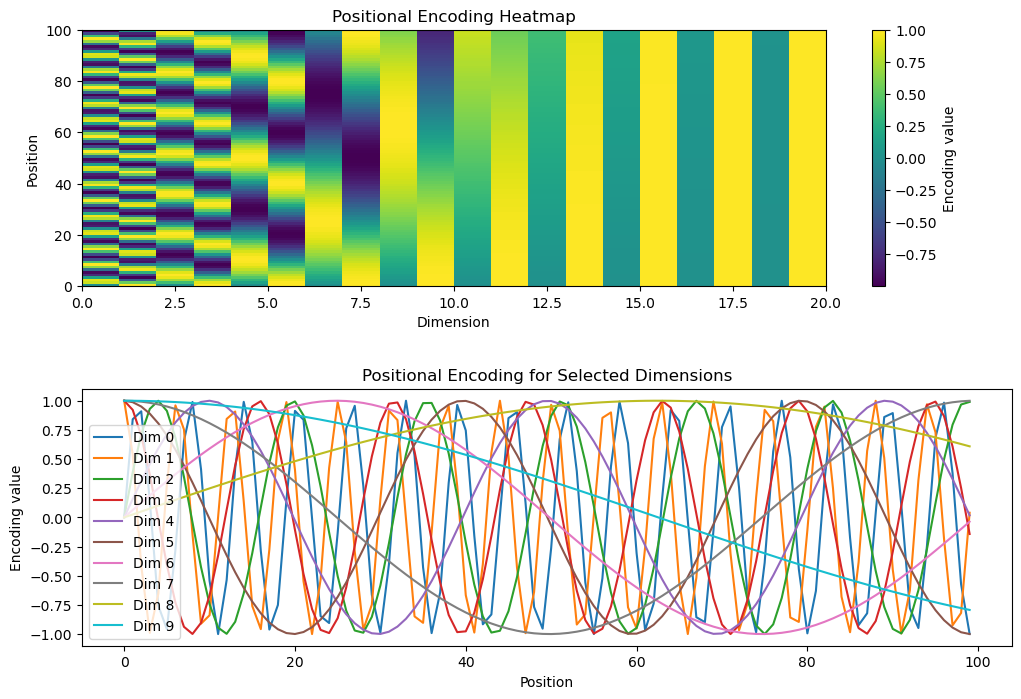

In [73]:
import matplotlib.pyplot as plt

d_model, length = 20, 100
PElayer = dl.IndexedPositionalEmbedding(d_model, max_length=length)
PE = PElayer.embs.detach().numpy().squeeze()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

c = ax[0].pcolormesh(PE, cmap="viridis")
fig.colorbar(c, ax=ax[0], label="Encoding value")
ax[0].set_title("Positional Encoding Heatmap")
ax[0].set_xlabel("Dimension")
ax[0].set_ylabel("Position")

for i in range(min(d_model, 10)):
    ax[1].plot(PE[:, i], label=f"Dim {i}")
ax[1].set_title("Positional Encoding for Selected Dimensions")
ax[1].set_xlabel("Position")
ax[1].set_ylabel("Encoding value")
ax[1].legend()

plt.subplots_adjust(hspace=0.4)
plt.show()


This script generates a heatmap of positional encodings for a given sequence length and dimensions (`d_model`). It plots the encoding values across positions (vertical axis) and dimensions (horizontal axis).

Furthermore, the bottom subplot displays line plots for selected dimensions (up to the first 10 for clarity) against positions. This more detailed view demonstrates how the encoding values change across positions for individual dimensions, giving insight into the oscillatory pattern created by the sine and cosine functions.